In [22]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/emails.csv


In [23]:
pd.set_option("display.max_column", None)
pd.set_option("display.max_row", 50)

#=== reading in of data
emails = pd.read_csv('./input/emails.csv')

#=== make a copy of the dataframe
emails_df = emails.copy()
print(emails_df.head())

#=== take a small portion of the data for better visualisation results
# emails_df = emails_df.sample(n = 200, random_state = 0)

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [24]:
#=== create a function to split text
import re
def split_text(text, match):	
    text = re.sub(r"\n\t", "", text)
    return re.split(match, text)

#=== create a function to extract proper text from the email body
def extract_body(text, substr):	
    result = re.split(substr, text)[-1]
    result = re.sub(r"([\n-])", "", result)
    return result

#=== clean up the data fields
#- function to extract email addresses
def extract_emails(text, substr):
    result = re.findall("[^\s]+@[\w]+.[\w]+", str(text))
    if substr not in text:
        result = ""
    return result

#- function to extract subject
def extract_subject(text):

    list_of_words = re.split("\s", text)
    words_to_drop = ["Subject:","re:","Re:","RE:","fw:","Fw:", "FW:"]

    desired_words = []
    for word in list_of_words:
        if word not in words_to_drop:
            desired_words.append(word)

    r = re.compile("[\w]{3,}")
    final_list = list(filter(r.match, desired_words))

    return final_list 

#- function to extract the name of entity
def extract_entity(text):	
    string = ""
    for i in text:
        string = string + " " + i

    list_of_emails = list(re.findall(r"@[\w]+", string))	
    result = []
    for item in list_of_emails:		
        result.append(item[1:])

    return set(result)

In [25]:
#=== store output in new column
emails_df["message_tidy"] = emails_df.message.apply(lambda x : split_text(x, "\n"))

#=== take a look at the output
print(emails_df.head())
print(emails_df.message.head(1))
print(emails_df.message_tidy.head(1))

                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                        message_tidy  
0  [Message-ID: <18782981.1075855378110.JavaMail....  
1  [Message-ID: <15464986.1075855378456.JavaMail....  
2  [Message-ID: <24216240.1075855687451.JavaMail....  
3  [Message-ID: <13505866.1075863688222.JavaMail....  
4  [Message-ID: <30922949.1075863688243.JavaMail....  
0    Message-ID: <18782981.1075855378110.JavaMail.e...
Name: message, dtype: object
0    [Message-ID: <18782981.1075855378110.JavaMail....
Name: m

In [26]:
#=== pull out useful data and post them into columns
emails_df["date"] = emails_df.message_tidy.apply(lambda x : x[1])
emails_df["sender_email"] = emails_df.message_tidy.apply(lambda x : x[2])
emails_df["recipient_email"] = emails_df.message_tidy.apply(lambda x : x[3])
emails_df["subject"] = emails_df.message_tidy.apply(lambda x : x[4])
emails_df["cc"] = emails_df.message_tidy.apply(lambda x : x[5])
emails_df["bcc"] = emails_df.message_tidy.apply(lambda x : x[9])
emails_df["body"] = emails_df.message.apply(lambda x : extract_body(x, r"X-FileName: [\w]*[\s]*[(Non\-Privileged).pst]*[\w-]*[.nsf]*").strip())

In [27]:
#- extract date info
emails_df["day_of_week"] = emails_df.loc[:,"date"].apply(lambda x : x[5:9])
emails_df.loc[:,"date"] = emails_df.loc[:,"date"].apply(lambda x : x[10:22])

#- extract sender and recipient email
emails_df.loc[:,"sender_email"] = emails_df.loc[:,"sender_email"].apply(lambda x : extract_emails(x, "From: "))
emails_df.loc[:,"recipient_email"] = emails_df.loc[:,"recipient_email"].apply(lambda x : extract_emails(x, "To: "))
emails_df.loc[:,"cc"] = emails_df.loc[:,"cc"].apply(lambda x : extract_emails(x, "Cc: "))
emails_df.loc[:,"bcc"] = emails_df.loc[:,"bcc"].apply(lambda x : extract_emails(x, "Bcc: "))
emails_df["all_recipient_emails"] = emails_df.apply(lambda x : list(x["recipient_email"]) + list(x["cc"]) + list(x["bcc"]), axis = 1)
emails_df["num_recipient"] = emails_df.recipient_email.apply(lambda x : len(x)) + emails_df.cc.apply(lambda x : len(x)) + \
                                emails_df.bcc.apply(lambda x : len(x))
    
#- extract sender and recipient entity info
emails_df["sender_entity"]    = emails_df.loc[:,"sender_email"].apply(lambda x : extract_entity(x))
emails_df["recipient_entity_to"] = emails_df.loc[:,"recipient_email"].apply(lambda x : extract_entity(x))
emails_df["recipient_entity_cc"] = emails_df.loc[:,"cc" ].apply(lambda x : extract_entity(x))
emails_df["recipient_entity_bcc"] = emails_df.loc[:,"bcc"].apply(lambda x : extract_entity(x))
emails_df["all_recipient_entities"] = emails_df.apply(lambda x : \
                                                 x["recipient_entity_to" ] | \
                                                 x["recipient_entity_cc" ] | \
                                                 x["recipient_entity_bcc"], axis = 1)

emails_df["sender_entity"] = emails_df.sender_entity.apply(lambda x : list(x))
emails_df["all_recipient_entities"] = emails_df.all_recipient_entities.apply(lambda x : list(x))

#- extract subject
emails_df.loc[:,"subject"] = emails_df.loc[:,"subject"].apply(lambda x : extract_subject(x))

#=== select and reorder the colums
df = emails_df.loc[:,["date","day_of_week","subject","body","sender_email","all_recipient_emails",
                                 "sender_entity","all_recipient_entities","num_recipient"]]  

print(df.head())

           date day_of_week  subject  \
0   14 May 2001         Mon       []   
1   4 May 2001          Fri       []   
2   18 Oct 2000         Wed   [test]   
3   23 Oct 2000         Mon       []   
4   31 Aug 2000         Thu  [Hello]   

                                                body  \
0                               Here is our forecast   
1  Traveling to have a business meeting takes the...   
2                     test successful.  way to go!!!   
3  Randy, Can you send me a schedule of the salar...   
4                  Let's shoot for Tuesday at 11:45.   

                sender_email       all_recipient_emails sender_entity  \
0  [phillip.allen@enron.com]     [tim.belden@enron.com]       [enron]   
1  [phillip.allen@enron.com]  [john.lavorato@enron.com]       [enron]   
2  [phillip.allen@enron.com]   [leah.arsdall@enron.com]       [enron]   
3  [phillip.allen@enron.com]    [randall.gay@enron.com]       [enron]   
4  [phillip.allen@enron.com]     [greg.piper@enron.com]  

In [28]:
#=== function to expand list into multiple rows
#- we examine just the "sender_email" and "all_recipient_emails"
#- we try to break up the list (in "all_recipient_emails") into multiple rows
from itertools import chain
def investigate(df_col1, df_col2):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.len()),"receive": list(chain.from_iterable(df_col2))})
    result_df.send = result_df.send.apply(lambda x : x[0])
    return result_df

In [29]:
df2a = investigate(df.sender_email, df.all_recipient_emails)
df2b = investigate(df.sender_entity, df.all_recipient_entities)

IndexError: list index out of range

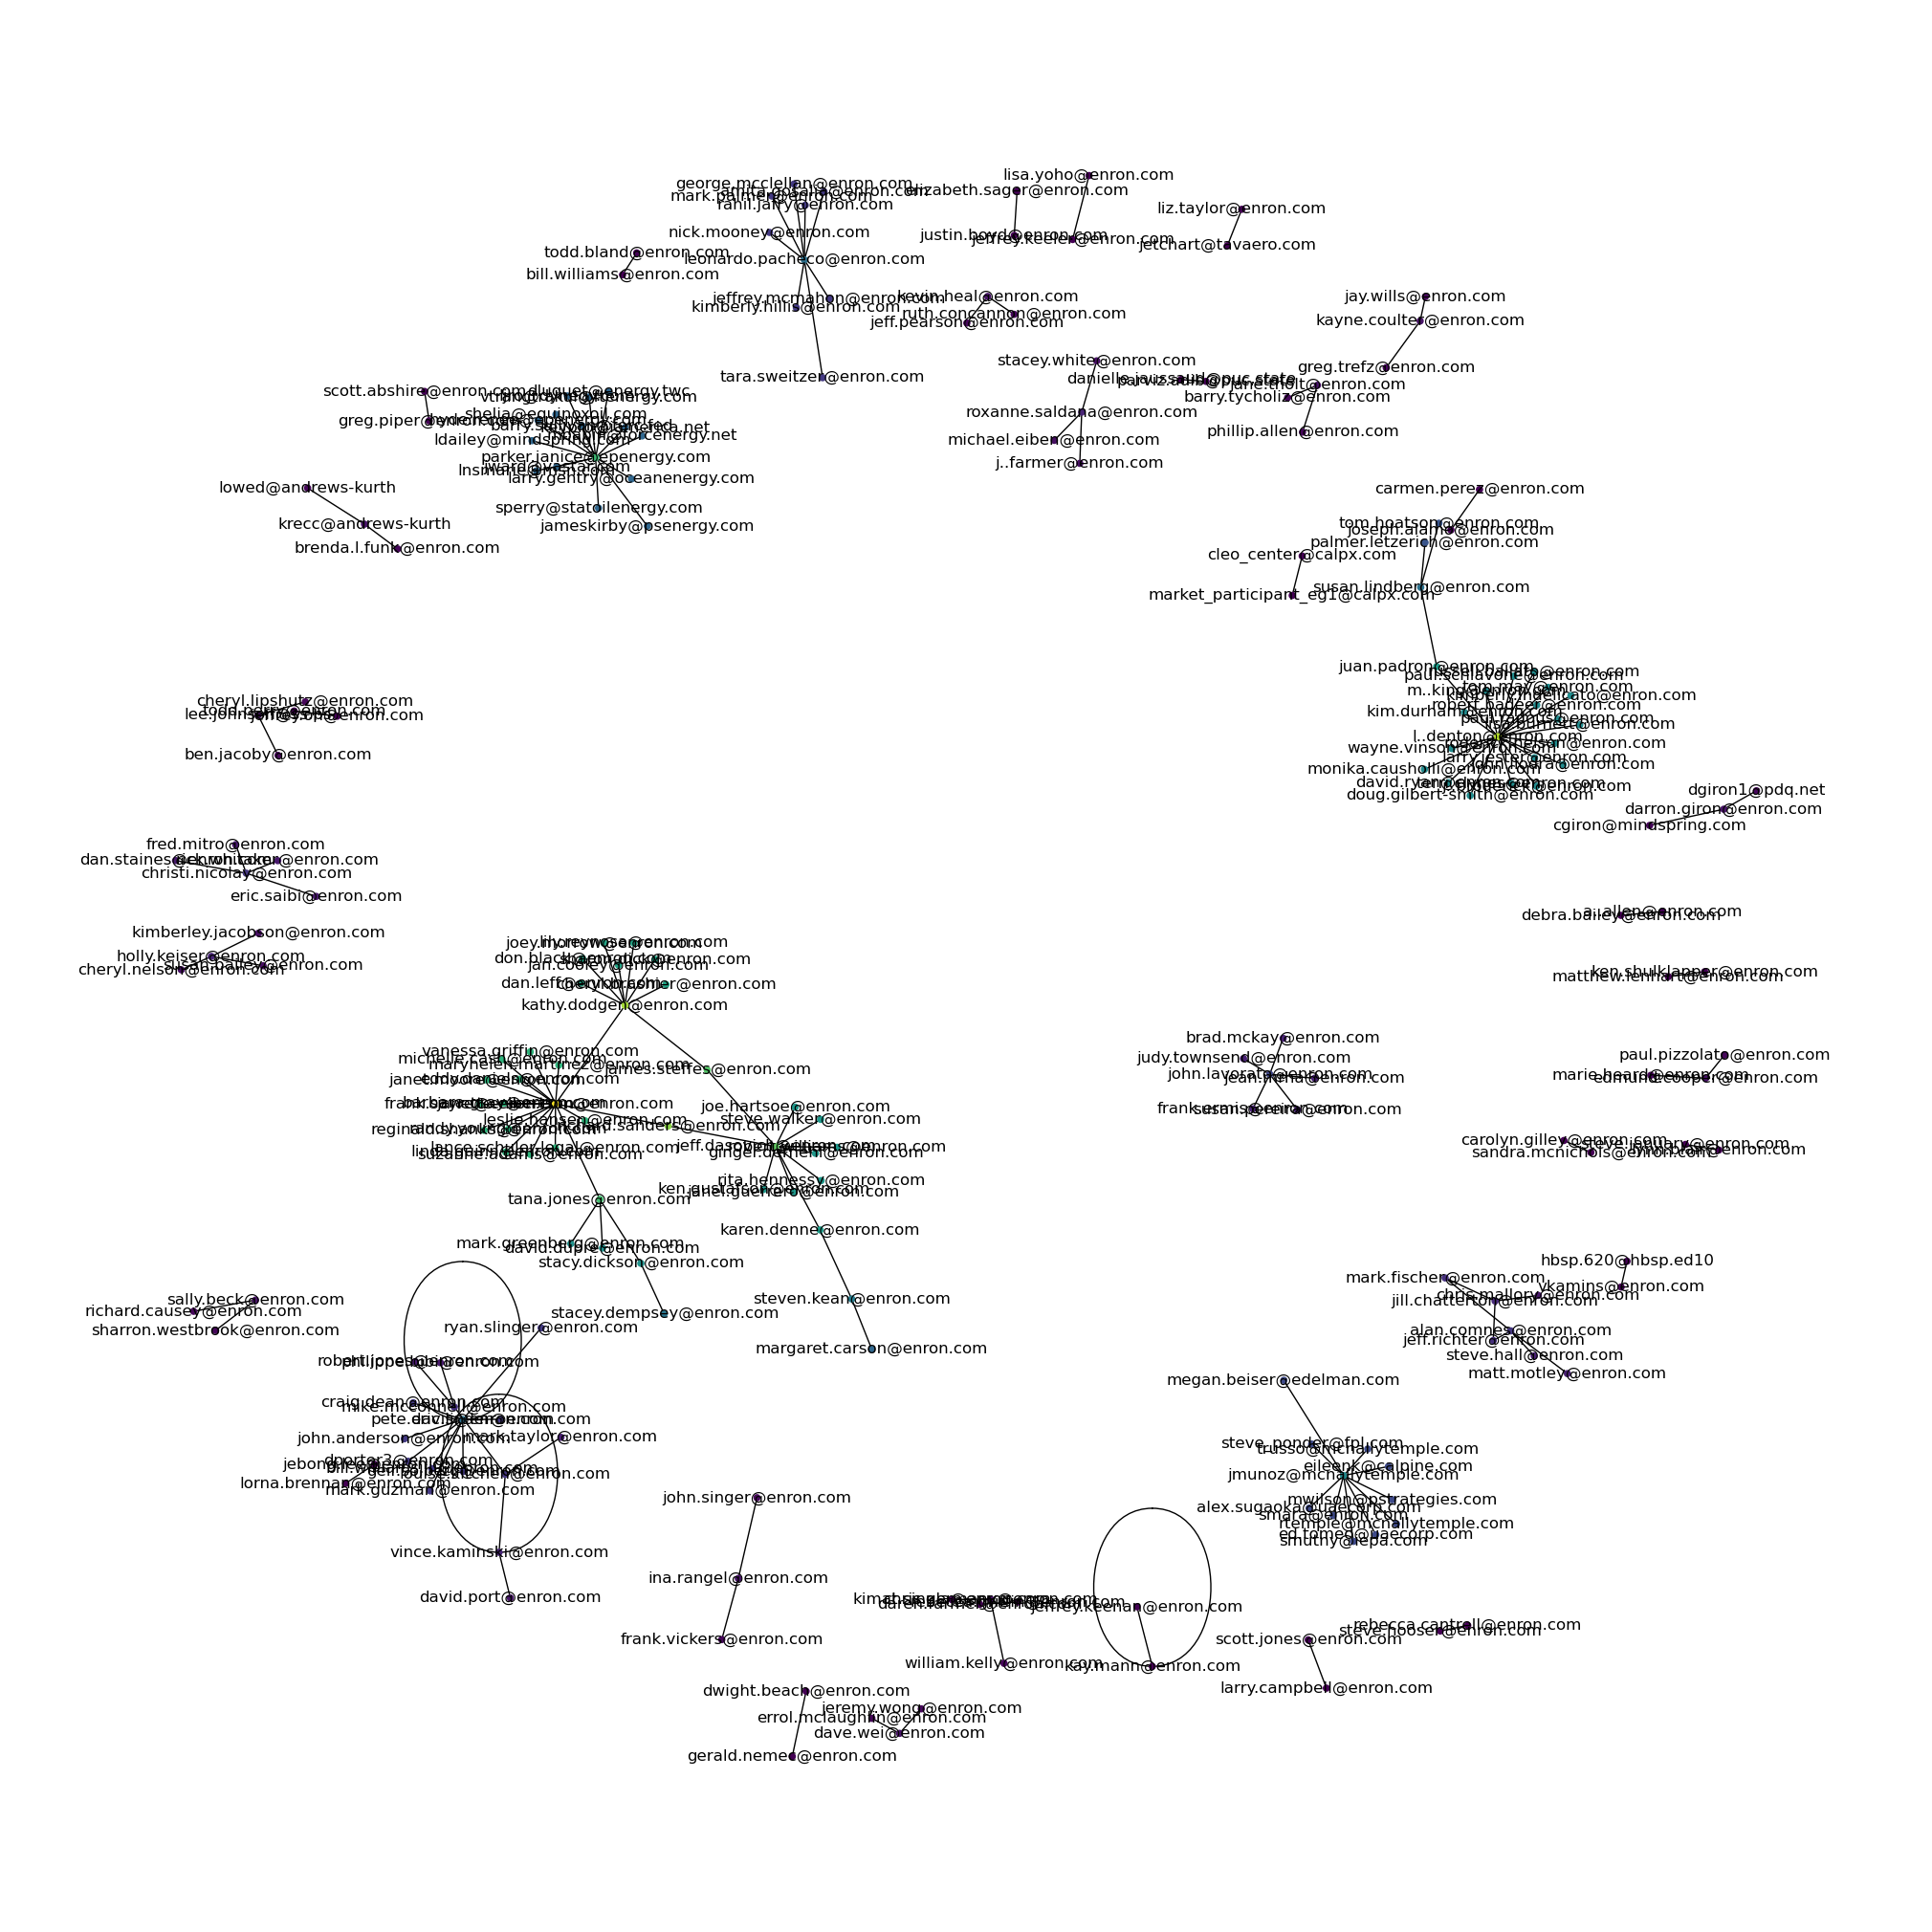

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

#=== for the sender and recipient emails
#- define the graph
G1 = nx.from_pandas_edgelist(df2a.sample(round(0.1*len(df2a)), random_state = 0), "send", "receive")

#- we define the closeness measure
closeness_G1 = nx.closeness_centrality(G1)
closeness_G1 = list(closeness_G1.values())

#- plot the network
plt.figure(figsize = (20,20))
pos1 = nx.spring_layout(G1, k=.1)
nx.draw(G1, pos1, node_size = 20, node_color = closeness_G1, with_labels = True)
plt.show()

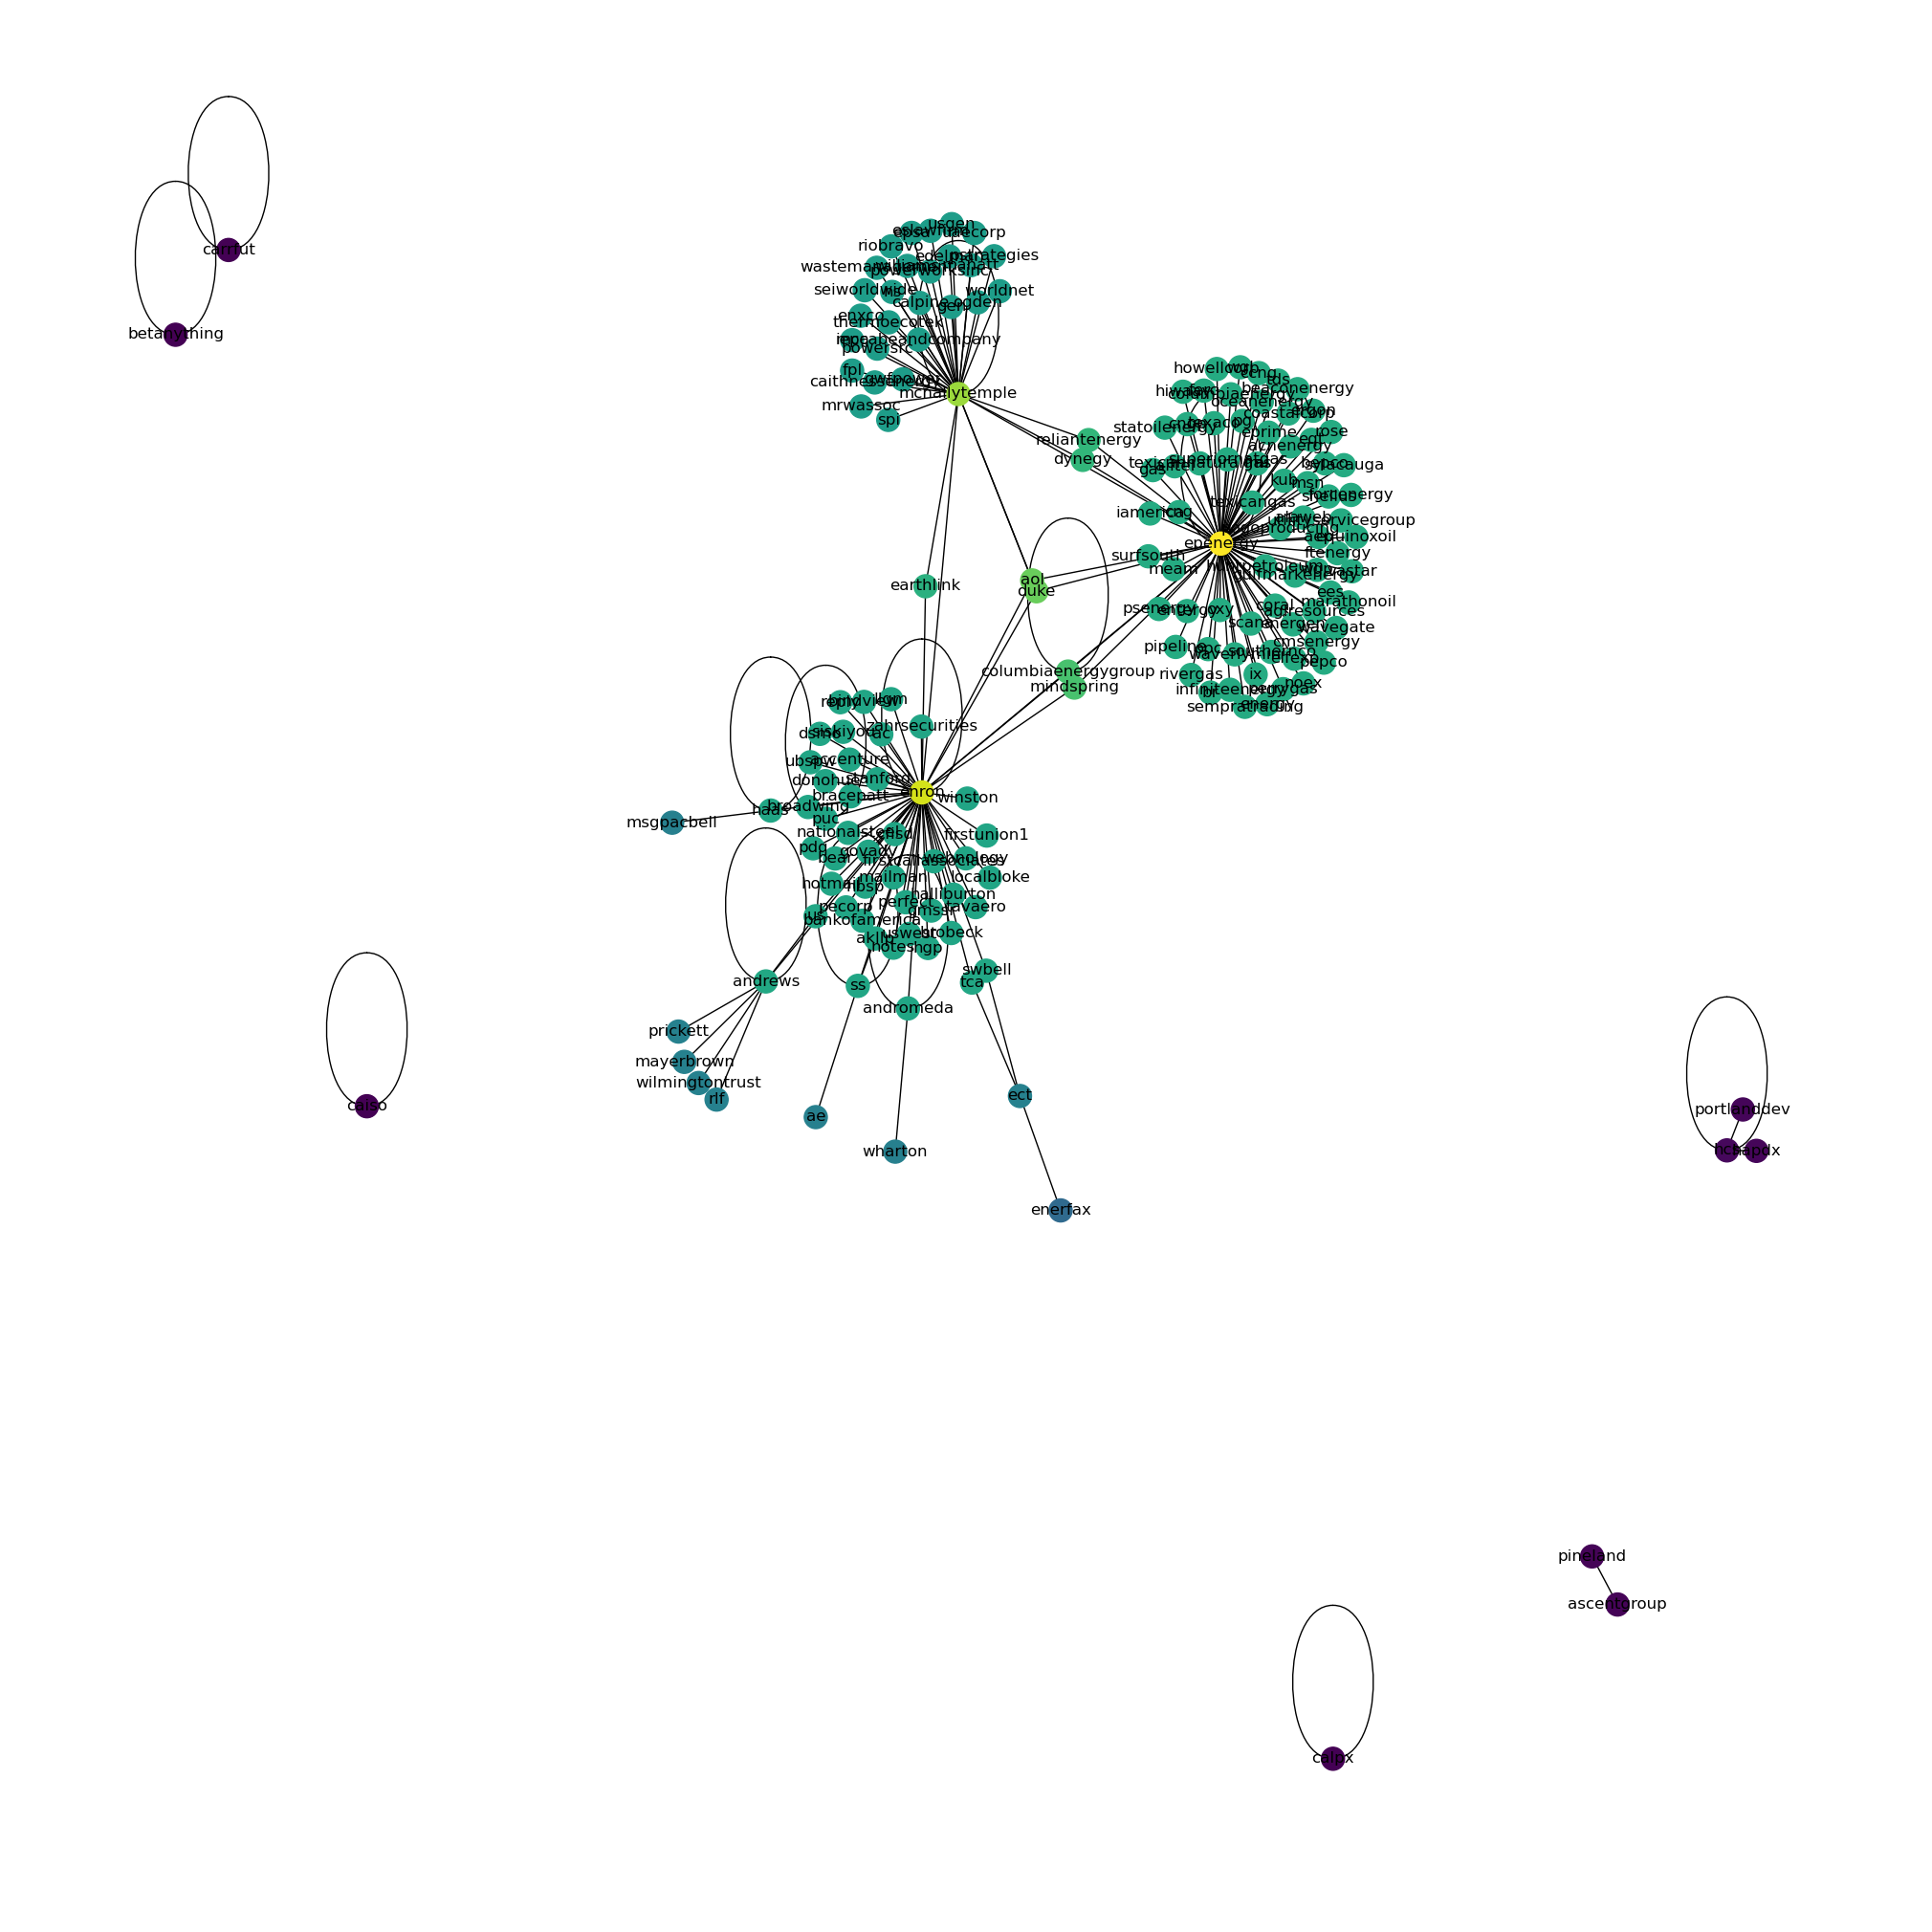

In [31]:
#=== for the sender and recipient entities
#- define the graph
G2 = nx.from_pandas_edgelist(df2b, "send", "receive")

#- we define the closeness measure
closeness_G2 = nx.closeness_centrality(G2)
closeness_G2 = list(closeness_G2.values())

#- plot the network
plt.figure(figsize = (20,20))
pos2 = nx.spring_layout(G2, k=.1)
nx.draw(G2, pos2, node_size = 300, node_color = closeness_G2,with_labels = True)
plt.show()